In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from prophet import Prophet

In [19]:
#Loading the dataset
        
df = pd.read_csv("API_dataset.csv")

In [20]:
# PREVIEW THE DATA

df.head()

,timestamp,endpoint,method,status_code,response_time_ms,response_size,user_id,service_name,env,region,payload_valid,expected_response_keys,response_payload_keys,anomaly_type,request_id,error_message
0,2025-04-16 04:46:13.774056,/checkout,GET,200,290.64,1778,U70117,user-service,staging,us-west,True,"['order_id', 'status']","['order_id', 'status']",none,f245d153-9a78-4fe2-82d3-b5175ceb6bf6,NaN
1,2025-04-21 12:26:13.774056,/profile,PUT,200,118.35,2161,U87021,product-service,dev,us-west,True,"['user_id', 'email', 'preferences']","['user_id', 'email', 'preferences']",none,e9672cb4-3daa-4023-8fba-cc6519c45936,NaN
2,2025-04-11 16:26:49.774056,/products,GET,200,40.33,1829,U21920,product-service,dev,us-east,True,"['product_id', 'price', 'inventory']","['product_id', 'price', 'inventory']",none,0a0f3497-0727-4bd8-bbc1-6a70fc2ffb51,NaN
3,2025-04-18 08:54:49.774056,/login,POST,200,223.67,1780,U89026,product-service,staging,eu-west,True,"['token', 'user_id']","['token', 'user_id']",none,ea70b404-1675-4688-a9f7-d60cd95692db,NaN
4,2025-04-17 01:19:27.774056,/search,PUT,200,55.24,0,U91052,order-service,staging,eu-west,False,['results'],[],empty_payload,7343ab15-72da-47c6-b57a-7acc9e9a60ee,NaN


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49026 entries, 0 to 49025
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   timestamp               49026 non-null  object 
 1   endpoint                49026 non-null  object 
 2   method                  49026 non-null  object 
 3   status_code             49026 non-null  int64  
 4   response_time_ms        49026 non-null  float64
 5   response_size           49026 non-null  int64  
 6   user_id                 49026 non-null  object 
 7   service_name            49026 non-null  object 
 8   env                     49026 non-null  object 
 9   region                  49026 non-null  object 
 10  payload_valid           49026 non-null  bool   
 11  expected_response_keys  49026 non-null  object 
 12  response_payload_keys   49026 non-null  object 
 13  anomaly_type            49026 non-null  object 
 14  request_id              49026 non-null

In [22]:
#COLUMN NAMES WITH DESCRIPTIONS

for col in df.columns:
    print(f"{col}: {df[col].dtype}")

timestamp: object
endpoint: object
method: object
status_code: int64
response_time_ms: float64
response_size: int64
user_id: object
service_name: object
env: object
region: object
payload_valid: bool
expected_response_keys: object
response_payload_keys: object
anomaly_type: object
request_id: object
error_message: object


# COLUMN DESCRIPTIONS
timestamp: Datetime when the API request occurred,
endpoint: API path (e.g., /login, /checkout),
method: HTTP method used (GET, POST, etc.),
status_code: HTTP response status,
response_time_ms: API response latency in milliseconds,
response_size: Size of the response payload in bytes,
user_id: Simulated user making the request,
service_name: Microservice that handled the request,
env: Deployment environment (prod, staging, dev),
region: Geographical location (e.g., us-east),
payload_valid: Boolean indicating if the response structure was valid,
expected_response_keys: Expected keys in the response,
response_payload_keys: Actual keys in the returned response,
anomaly_type: Injected anomaly label (if any),
request_id: Unique ID for request tracing,
error_message: Error detail for failed requests


In [23]:
# CHECK UNIQUE VALUES
print(df['method'].unique())
print(df['status_code'].value_counts())
print(df['env'].value_counts())
print(df['anomaly_type'].value_counts())

['GET' 'PUT' 'POST']
200    44066
503     1997
404     1978
500      985
Name: status_code, dtype: int64
prod       16451
staging    16442
dev        16133
Name: env, dtype: int64
none             45992
status_spike      1050
empty_payload     1005
high_latency       979
Name: anomaly_type, dtype: int64


# PART 2: EDA

In [24]:
# 1. Dataset Shape
print("Shape of dataset:", df.shape)

Shape of dataset: (49026, 16)


In [25]:
# 2. Data Types & Memory Info
print("\nData Types & Memory Info:")
df.info()


Data Types & Memory Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49026 entries, 0 to 49025
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   timestamp               49026 non-null  object 
 1   endpoint                49026 non-null  object 
 2   method                  49026 non-null  object 
 3   status_code             49026 non-null  int64  
 4   response_time_ms        49026 non-null  float64
 5   response_size           49026 non-null  int64  
 6   user_id                 49026 non-null  object 
 7   service_name            49026 non-null  object 
 8   env                     49026 non-null  object 
 9   region                  49026 non-null  object 
 10  payload_valid           49026 non-null  bool   
 11  expected_response_keys  49026 non-null  object 
 12  response_payload_keys   49026 non-null  object 
 13  anomaly_type            49026 non-null  object 
 14  request_id 

In [26]:
# 3. Convert timestamp (if not already converted)
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [27]:
# 4. Basic Statistics
print("\nSummary statistics for numeric columns:")
print(df.describe())


Summary statistics for numeric columns:
        status_code  response_time_ms  response_size
count  49026.000000      49026.000000   49026.000000
mean     226.600233        241.630971    1320.625138
std       80.743559        300.886553     673.684383
min      200.000000          0.010000       0.000000
25%      200.000000         61.570000     981.000000
50%      200.000000        150.665000    1417.000000
75%      200.000000        312.377500    1786.000000
max      503.000000       6468.020000    3591.000000


In [28]:
# 5. Null Values Check
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
timestamp                     0
endpoint                      0
method                        0
status_code                   0
response_time_ms              0
response_size                 0
user_id                       0
service_name                  0
env                           0
region                        0
payload_valid                 0
expected_response_keys        0
response_payload_keys         0
anomaly_type                  0
request_id                    0
error_message             44066
dtype: int64


In [29]:
# 6. Unique Values Count
print("\nUnique value counts for key categorical columns:")
print("Endpoints:", df['endpoint'].nunique())
print("HTTP Methods:", df['method'].nunique())
print("Services:", df['service_name'].nunique())
print("Users:", df['user_id'].nunique())
print("Environments:", df['env'].nunique())
print("Regions:", df['region'].nunique())


Unique value counts for key categorical columns:
Endpoints: 5
HTTP Methods: 3
Services: 4
Users: 37727
Environments: 3
Regions: 3


In [30]:
# 7. Status Code Distribution
print("\nStatus code distribution:")
print(df['status_code'].value_counts())


Status code distribution:
200    44066
503     1997
404     1978
500      985
Name: status_code, dtype: int64


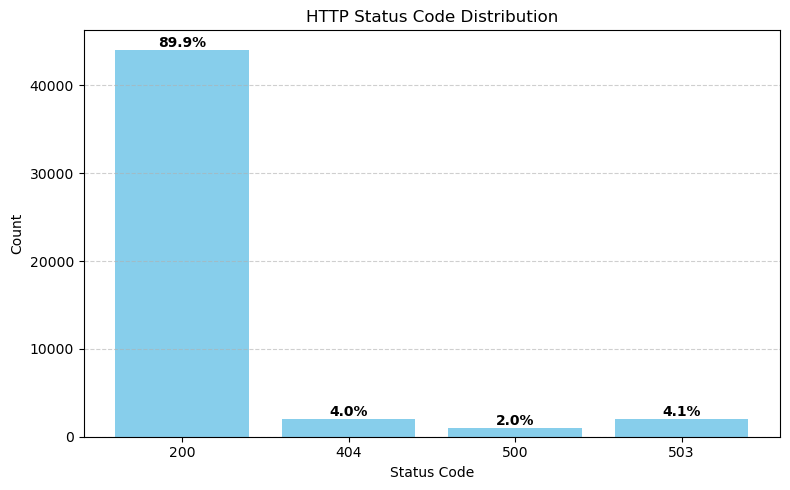

In [31]:
# Get value counts and calculate percentage
status_counts = df['status_code'].value_counts().sort_index()
status_percent = (status_counts / status_counts.sum()) * 100

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(status_counts.index.astype(str), status_counts.values, color='skyblue')
plt.title("HTTP Status Code Distribution")
plt.xlabel("Status Code")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add percentage labels on top of bars
for bar, pct in zip(bars, status_percent):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{pct:.1f}%",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


### 1. REQUEST OVER TIME

Description:
Calculates the total number of API requests made in each hourly window. Useful for understanding system usage patterns over time.

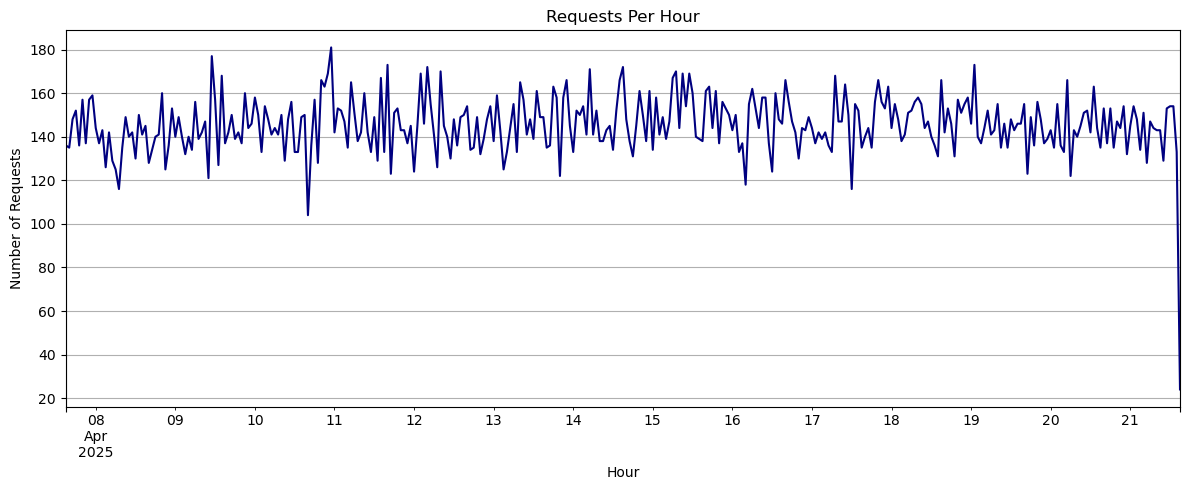

In [32]:
df['hour'] = df['timestamp'].dt.floor('H')  # round to the hour

requests_per_hour = df.groupby('hour').size()

# Plot
requests_per_hour.plot(figsize=(12, 5), title='Requests Per Hour', color='navy')
plt.xlabel("Hour")
plt.ylabel("Number of Requests")
plt.grid(True)
plt.tight_layout()
plt.show()

### INSIGHT

The number of API requests per hour remains fairly consistent, ranging mostly between 130 and 160 requests. A few sharp drops and occasional spikes are observed, which could indicate irregular traffic patterns or potential gaps in data logging. These fluctuations may warrant further investigation in the anomaly detection phase.

### 2. Average Response Time per Hour

Description:
Computes the average response time (in milliseconds) of all API calls grouped by hour. Helps visualize performance consistency or degradation over time.

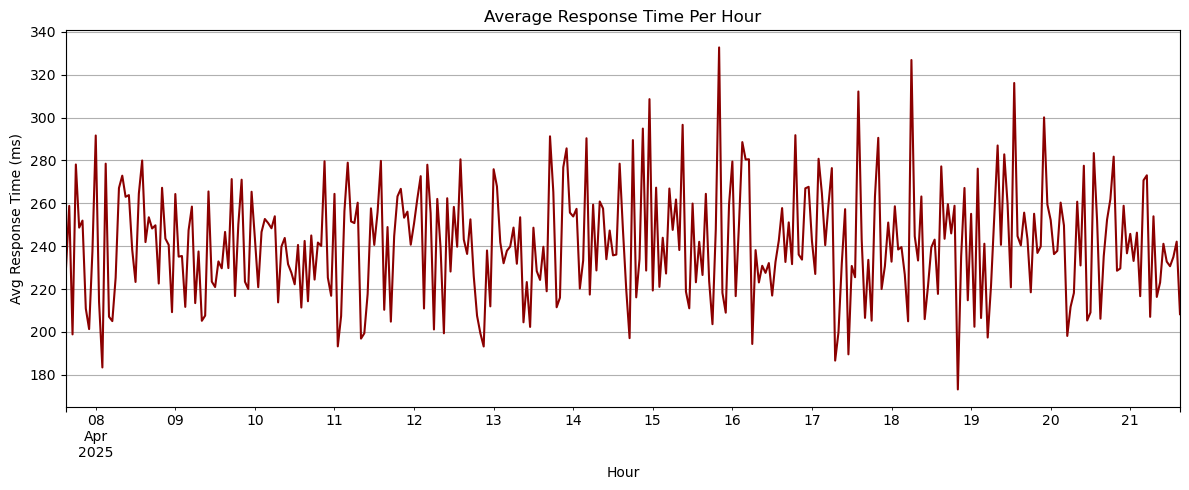

In [33]:
latency_per_hour = df.groupby('hour')['response_time_ms'].mean()

# Plot
latency_per_hour.plot(figsize=(12, 5), title='Average Response Time Per Hour', color='darkred')
plt.xlabel("Hour")
plt.ylabel("Avg Response Time (ms)")
plt.grid(True)
plt.tight_layout()
plt.show()


### INSIGHT

The average response time generally ranges between 220 ms and 280 ms, indicating consistent performance across most hours. However, several noticeable spikes above 300 ms suggest intermittent latency issues, which may require further investigation at the service or endpoint level.

### 3. 5xx Error Rate Over Time

Description:
Calculates the percentage of requests that resulted in server-side errors (status_code 500–599) for each hour. Useful for identifying periods of backend instability.

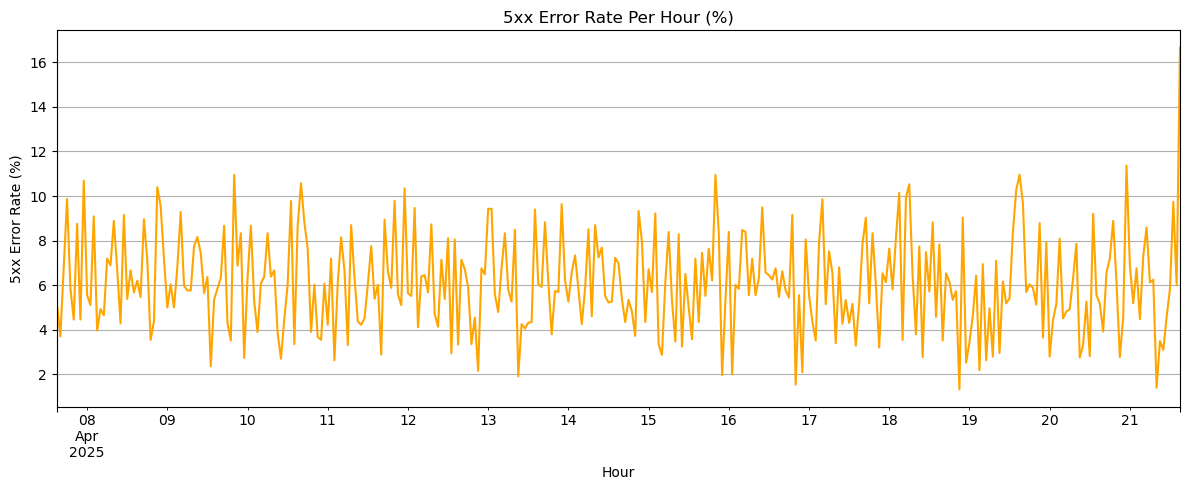

In [34]:
# Create a 5xx error flag
df['is_5xx'] = df['status_code'].between(500, 599)

error_rate_per_hour = df.groupby('hour')['is_5xx'].mean() * 100  # % of 5xx

# Plot
error_rate_per_hour.plot(figsize=(12, 5), title='5xx Error Rate Per Hour (%)', color='orange')
plt.xlabel("Hour")
plt.ylabel("5xx Error Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


### INSIGHT

The 5xx error rate fluctuates between 3% and 10% for most hours, indicating occasional backend instability. Several peaks above 12% suggest brief but significant spikes in server-side failures that could impact user experience or signal deeper system issues.

### 4. Avg Response Time by Endpoint

Description:
Computes the average response time for each API endpoint. Highlights which parts of the system are slower or potentially heavier in processing.

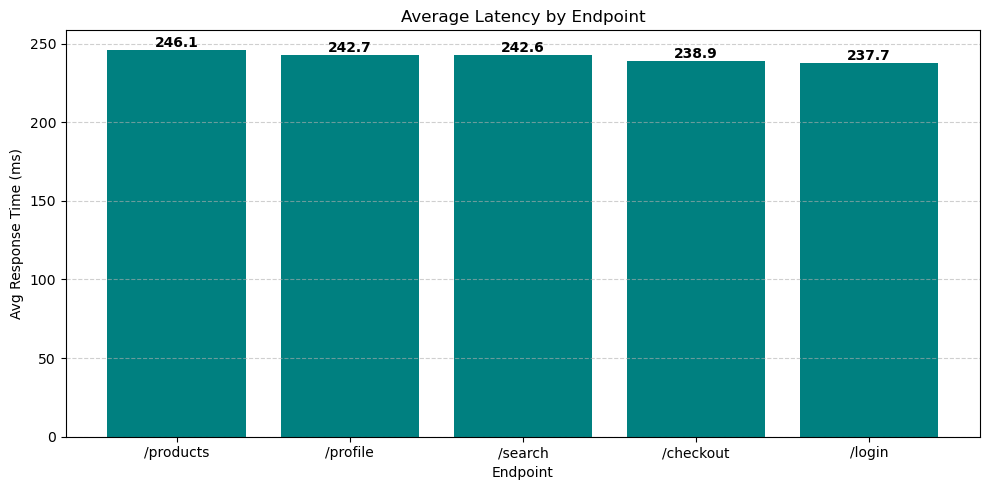

In [35]:
import matplotlib.pyplot as plt

# Compute average latency by endpoint
avg_latency_by_endpoint = df.groupby('endpoint')['response_time_ms'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 5))
bars = plt.bar(avg_latency_by_endpoint.index, avg_latency_by_endpoint.values, color='teal')
plt.title('Average Latency by Endpoint')
plt.ylabel("Avg Response Time (ms)")
plt.xlabel("Endpoint")

# Remove vertical grid, keep only horizontal
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add exact values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.1f}",
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()


### INSIGHT

All endpoints show a relatively similar average response time, ranging around 240–250 ms. /products has the highest average latency, while /login is slightly faster than the rest. The uniformity suggests consistent backend performance, but even small differences can matter under high load conditions.

### 5. Top 10 Users by Error Count

Description:
Identifies the top 10 users who generated the highest number of failed requests (status_code ≥ 400). Useful for spotting patterns in faulty or problematic clients.

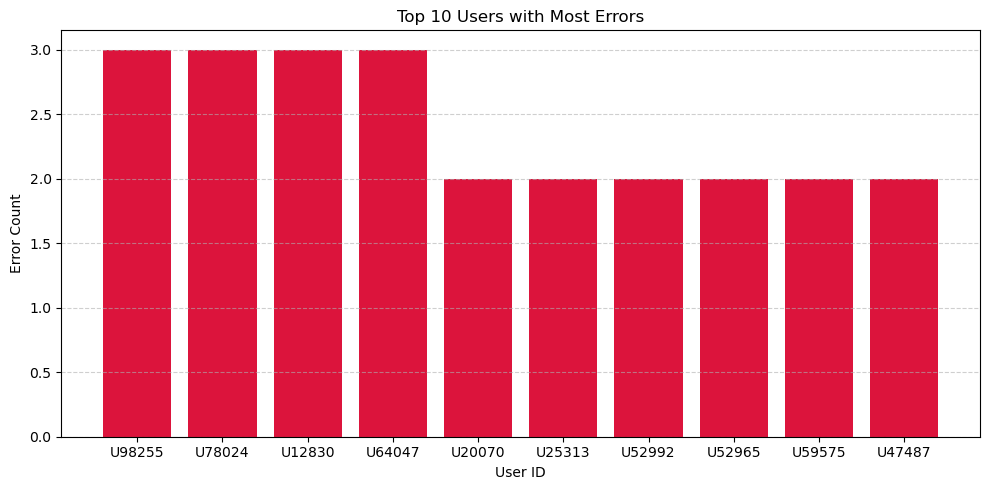

In [36]:
# Create error flag and group top 10 users
df['is_error'] = df['status_code'] >= 400
top_error_users = df[df['is_error']].groupby('user_id').size().sort_values(ascending=False).head(10)

# Plot without labels on top
plt.figure(figsize=(10, 5))
plt.bar(top_error_users.index, top_error_users.values, color='crimson')
plt.title('Top 10 Users with Most Errors')
plt.xlabel("User ID")
plt.ylabel("Error Count")

# Only show horizontal grid lines
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


### INSIGHT

A small group of users are responsible for the highest number of failed requests, with four users each triggering 3 errors. This concentration suggests potential issues with specific clients or repeated user behavior worth further investigation.

### 6. Silent Failure
A silent failure occurs when the API returns a 200 OK status code, but the actual payload is empty or invalid. These are particularly dangerous because they go unnoticed — everything appears successful while critical data is missing or malformed.

In [37]:
silent_failures = df[
    (df['status_code'] == 200) & (df['payload_valid'] == False)
]

print("Silent failures count:", silent_failures.shape[0])
silent_failures['endpoint'].value_counts()


Silent failures count: 949


/profile     216
/checkout    194
/search      191
/login       178
/products    170
Name: endpoint, dtype: int64

### INSIGHT 

A total of 949 silent failures were detected, where the API returned a 200 OK status but the payload was invalid. The highest number of such failures occurred on the /profile and /checkout endpoints, indicating that these may be returning misleading responses more frequently and should be prioritized for debugging or validation logic updates.

### 7. Missing Expected Keys

Even when a payload is technically marked as valid, it may still be incomplete if required keys are missing. This anomaly helps detect partial responses where the structure is incorrect, leading to downstream issues in data processing or analytics.

In [38]:
def key_mismatch(row):
    try:
        expected = set(eval(row['expected_response_keys']))
        actual = set(eval(row['response_payload_keys']))
        return not expected.issubset(actual)
    except:
        return False

df['key_mismatch'] = df.apply(key_mismatch, axis=1)
print("Payload schema mismatches:", df['key_mismatch'].sum())


Payload schema mismatches: 2839


### INSIGHT

A total of 2,839 payload schema mismatches were identified where expected keys were missing in the API response. These mismatches indicate frequent structural inconsistencies in the data returned by APIs, which could silently impact downstream processing, reporting, or machine learning pipelines relying on complete data.

### 8. Volume Drop Detection

This anomaly identifies time windows with a sudden decrease in the number of API requests, compared to normal traffic patterns. It can indicate automation pipeline failures, broken data ingestion, or periods of system downtime that may otherwise go undetected.

In [39]:
requests_hourly = df.groupby(df['timestamp'].dt.floor('H')).size()
rolling_avg = requests_hourly.rolling(window=6, min_periods=1).mean()
volume_drop = requests_hourly[requests_hourly < (0.5 * rolling_avg)]

print("Volume drop hours:", volume_drop.shape[0])
volume_drop.head()


Volume drop hours: 1


timestamp
2025-04-21 15:00:00    24
dtype: int64

### INSIGHT

Only one significant volume drop was detected, occurring on April 21, 2025 at 3:00 PM, where the number of API requests fell well below 50% of the rolling average. This could indicate a brief pipeline failure, partial outage, or an interruption in log collection during that hour.

### 9. High Latency Anomalies

A latency spike occurs when an endpoint's response time is significantly higher than usual, based on statistical thresholds. These anomalies help uncover performance degradation that may not yet trigger outright failures but affect user experience or throughput.

In [40]:
high_latency = df.groupby('endpoint')['response_time_ms'].transform(
    lambda x: x > x.mean() + 2 * x.std()
)
df['latency_anomaly'] = high_latency

print("High latency anomalies:", df['latency_anomaly'].sum())


High latency anomalies: 1937


### INSIGHT

A total of 1,937 high latency anomalies were detected where response times exceeded two standard deviations above the mean for their respective endpoints. This indicates frequent performance degradation, which may not cause outright failures but can significantly affect user experience and system throughput.

### 10. Region-Specific Failures

This anomaly highlights when a specific deployment region (e.g., us-east, eu-west) experiences a disproportionately high number of errors. It can point to infrastructure issues, regional deployments gone wrong, or CDN/network latency impacting specific user groups.

In [41]:
region_errors = df[df['status_code'] >= 500].groupby('region').size()
region_total = df.groupby('region').size()
error_rate_by_region = (region_errors / region_total).sort_values(ascending=False)

print(error_rate_by_region)

region
us-west    0.063666
eu-west    0.059610
us-east    0.059165
dtype: float64


### INSIGHT

The us-west region experienced the highest rate of server-side errors (6.37%), slightly higher than eu-west and us-east, both of which were around 5.9%. While the differences are small, this suggests that us-west may be slightly more prone to infrastructure or deployment issues and could benefit from closer monitoring or capacity review.

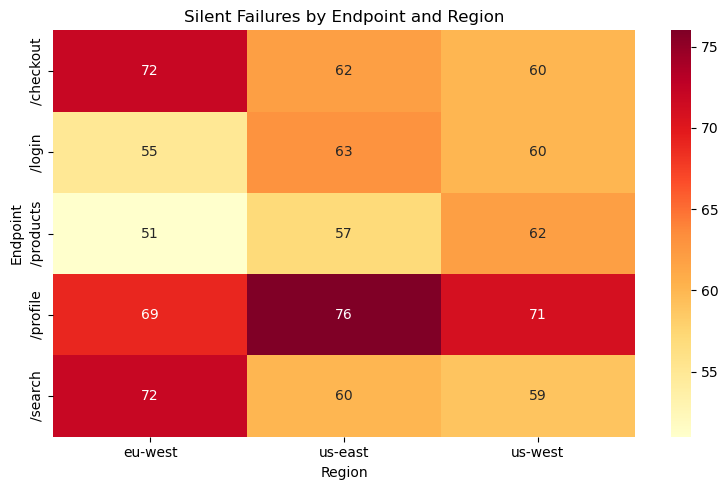

In [42]:
# Pivot table
heatmap_data = silent_failures.pivot_table(index='endpoint', columns='region', aggfunc='size', fill_value=0)

# Plot
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd')
plt.title("Silent Failures by Endpoint and Region")
plt.xlabel("Region")
plt.ylabel("Endpoint")
plt.tight_layout()
plt.show()

# PART 3: RULE BASED ANOMALY DETECTION

### Enhanced 503 Spike Detection by Region and Hour

In [43]:
# Floor timestamp to hourly
df['hour'] = df['timestamp'].dt.floor('H')

# Group by region and hour — count 503 errors
status_503_by_region_hour = df[df['status_code'] == 503].groupby(['region', 'hour']).size().reset_index(name='503_count')

# Compute rolling average per region
status_503_by_region_hour['rolling_avg'] = (
    status_503_by_region_hour
    .groupby('region')['503_count']
    .transform(lambda x: x.rolling(window=6, min_periods=1).mean())
)

# Identify spike (count > 2 × rolling average)
status_503_by_region_hour['spike'] = status_503_by_region_hour['503_count'] > 2 * status_503_by_region_hour['rolling_avg']

# Optional: % above average
status_503_by_region_hour['percent_above_avg'] = (
    (status_503_by_region_hour['503_count'] - status_503_by_region_hour['rolling_avg']) / status_503_by_region_hour['rolling_avg']
) * 100

# Filter for spikes only
spike_details_by_region = status_503_by_region_hour[status_503_by_region_hour['spike']]

# Show top rows
spike_details_by_region.head()


,region,hour,503_count,rolling_avg,spike,percent_above_avg
21,eu-west,2025-04-08 17:00:00,5,2.166667,True,130.769231
228,eu-west,2025-04-18 22:00:00,7,2.666667,True,162.500000
240,eu-west,2025-04-19 11:00:00,5,2.166667,True,130.769231
256,eu-west,2025-04-20 03:00:00,6,2.500000,True,140.000000
387,us-east,2025-04-12 12:00:00,4,1.833333,True,118.181818


### Error Clustering by Service

In [44]:
# Keep original logic
service_total = df.groupby('service_name').size()
service_5xx = df[df['status_code'] >= 500].groupby('service_name').size()
service_5xx_rate = (service_5xx / service_total).fillna(0)

# Lower threshold to 5%
print(service_5xx_rate[service_5xx_rate > 0.05])


service_name
auth-service       0.062214
order-service      0.061113
product-service    0.059760
user-service       0.060219
dtype: float64


In [45]:
# Filter for 404s
errors_404 = df[df['status_code'] == 404]

# Count per hour
errors_404_hourly = errors_404.groupby(errors_404['timestamp'].dt.floor('H')).size()

# Rolling baseline
rolling_avg_404 = errors_404_hourly.rolling(window=6, min_periods=1).mean()

# Spike detection (flexible threshold)
spike_404 = errors_404_hourly[errors_404_hourly > 1.5 * rolling_avg_404]

# Create output DataFrame
spike_404_df = pd.DataFrame({
    'hour': spike_404.index,
    '404_count': spike_404.values,
    'rolling_avg': rolling_avg_404.loc[spike_404.index].values
})
spike_404_df['percent_above_avg'] = (
    (spike_404_df['404_count'] - spike_404_df['rolling_avg']) / spike_404_df['rolling_avg']
) * 100

# Display
print("404 Surge Detected:")
display(spike_404_df.head())


404 Surge Detected:


,hour,404_count,rolling_avg,percent_above_avg
0,2025-04-08 13:00:00,10,5.666667,76.470588
1,2025-04-09 02:00:00,8,5.000000,60.000000
2,2025-04-10 03:00:00,10,5.166667,93.548387
3,2025-04-10 11:00:00,12,6.833333,75.609756
4,2025-04-10 19:00:00,7,4.000000,75.000000


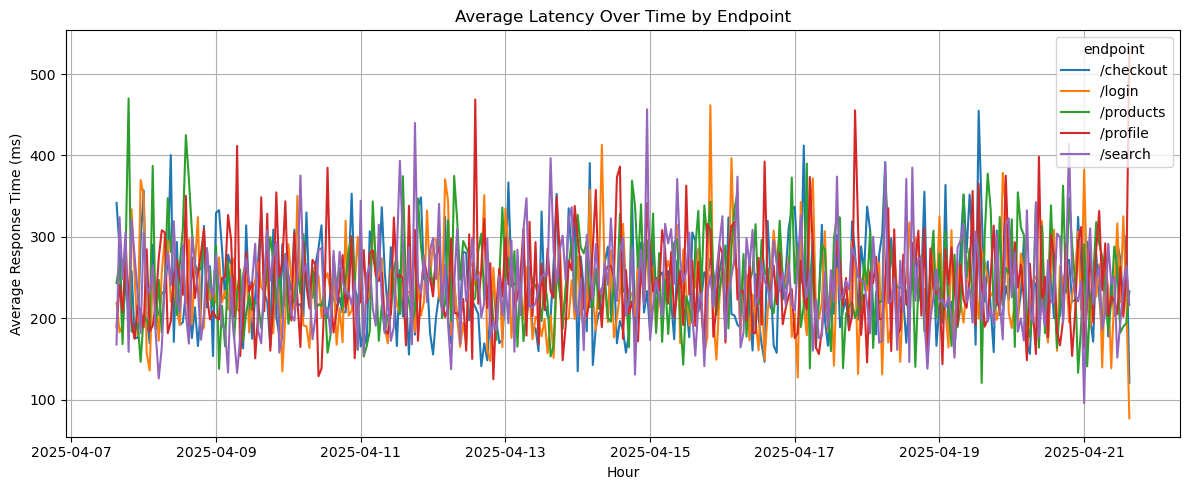

In [46]:
# Round timestamp to hourly
df['hour'] = df['timestamp'].dt.floor('H')

# Group and average response time per endpoint over time
avg_latency = df.groupby(['hour', 'endpoint'])['response_time_ms'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=avg_latency, x='hour', y='response_time_ms', hue='endpoint')
plt.title('Average Latency Over Time by Endpoint')
plt.xlabel('Hour')
plt.ylabel('Average Response Time (ms)')
plt.grid(True)
plt.tight_layout()
plt.show()


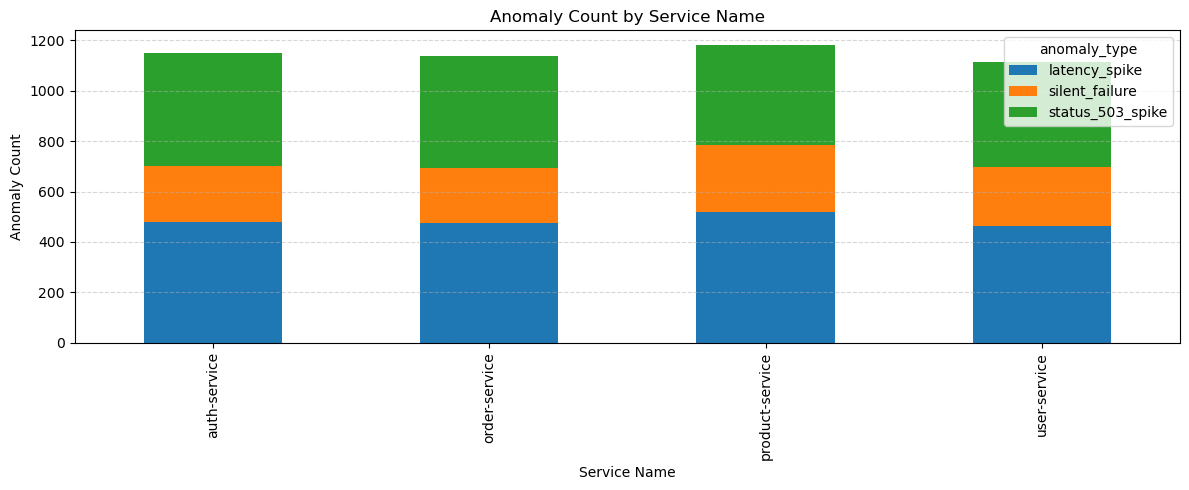

In [47]:
# Latency spike (example threshold)
df['latency_spike'] = df['response_time_ms'] > df['response_time_ms'].mean() + 2 * df['response_time_ms'].std()

# Silent failure
df['silent_failure'] = (df['status_code'] == 200) & (df['payload_valid'] == False)

# Volume drop 
df['volume_drop'] = False  

# Status 503 spike
df['status_503_spike'] = df['status_code'] == 503

anomaly_cols = ['latency_spike', 'silent_failure', 'volume_drop', 'status_503_spike']
df['anomaly_type'] = df[anomaly_cols].idxmax(axis=1, skipna=True)
anomalies = df[df[anomaly_cols].any(axis=1)]
count_by_service = anomalies.groupby(['service_name', 'anomaly_type']).size().unstack(fill_value=0)

count_by_service.plot(kind='bar', stacked=True, figsize=(12, 5))
plt.title('Anomaly Count by Service Name')
plt.xlabel('Service Name')
plt.ylabel('Anomaly Count')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


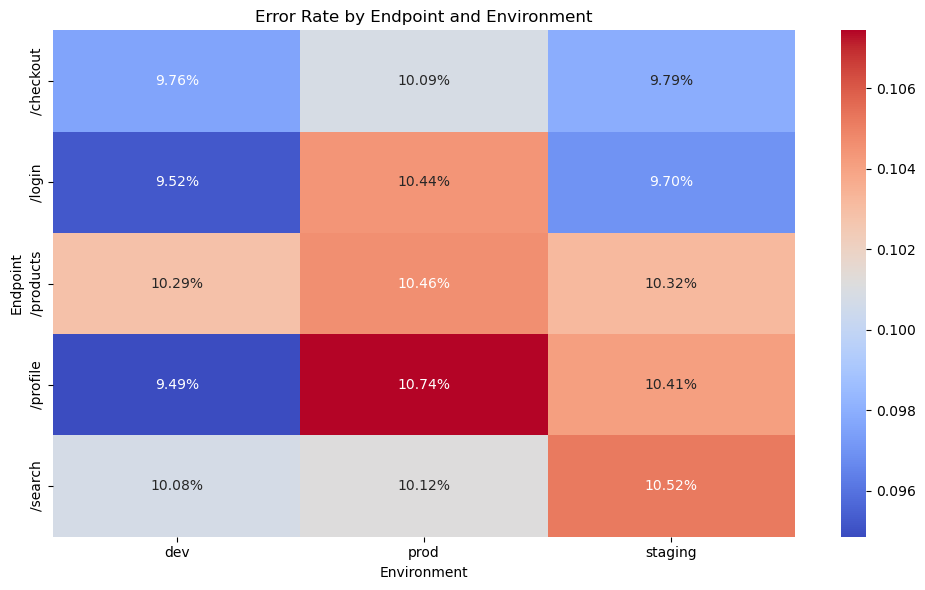

In [48]:
# Create error flag
df['is_error'] = df['status_code'] >= 400

# Pivot table: error rate by endpoint and environment
error_rate = df.pivot_table(
    index='endpoint',
    columns='env',
    values='is_error',
    aggfunc='mean'
)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(error_rate, annot=True, fmt=".2%", cmap="coolwarm")
plt.title("Error Rate by Endpoint and Environment")
plt.xlabel("Environment")
plt.ylabel("Endpoint")
plt.tight_layout()
plt.show()


C:\Users\harsh\AppData\Local\Temp\ipykernel_18828\2025847253.py:17: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from current font.
  plt.tight_layout()
C:\Users\harsh\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


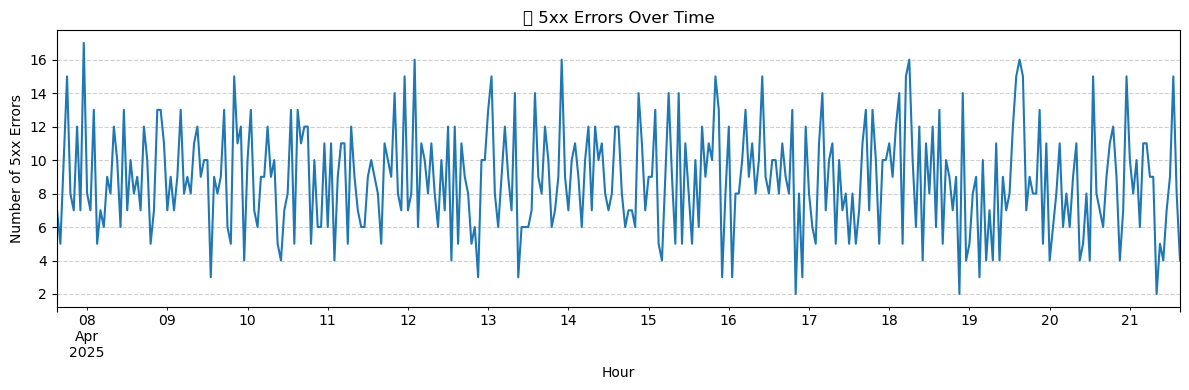

In [49]:
# Create 5xx flag
df['is_5xx'] = df['status_code'] >= 500

# Round timestamps to hourly
df['hour'] = df['timestamp'].dt.floor('H')

# Count 5xx errors per hour
errors_per_hour = df.groupby('hour')['is_5xx'].sum()

# Plot
plt.figure(figsize=(12, 4))
errors_per_hour.plot()
plt.title("⏱️ 5xx Errors Over Time")
plt.xlabel("Hour")
plt.ylabel("Number of 5xx Errors")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


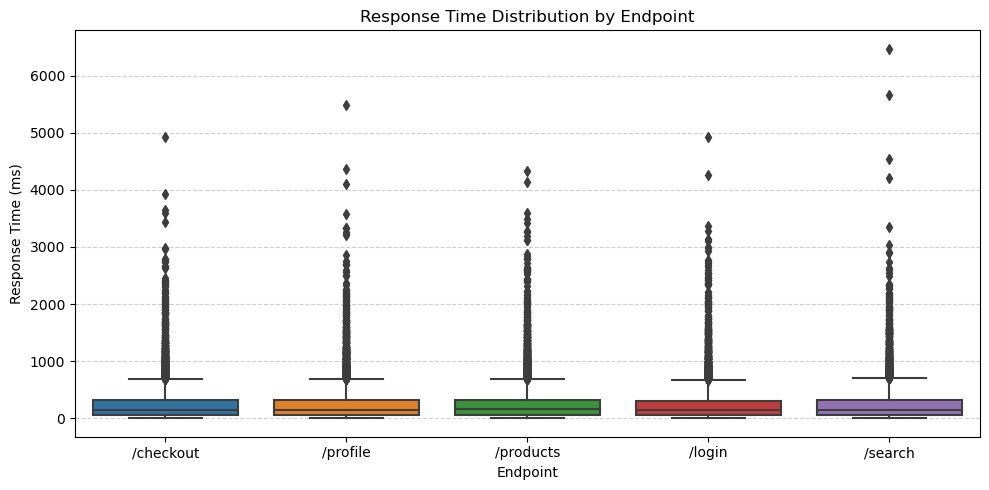

In [50]:
# Plot
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='endpoint', y='response_time_ms')
plt.title("Response Time Distribution by Endpoint")
plt.xlabel("Endpoint")
plt.ylabel("Response Time (ms)")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


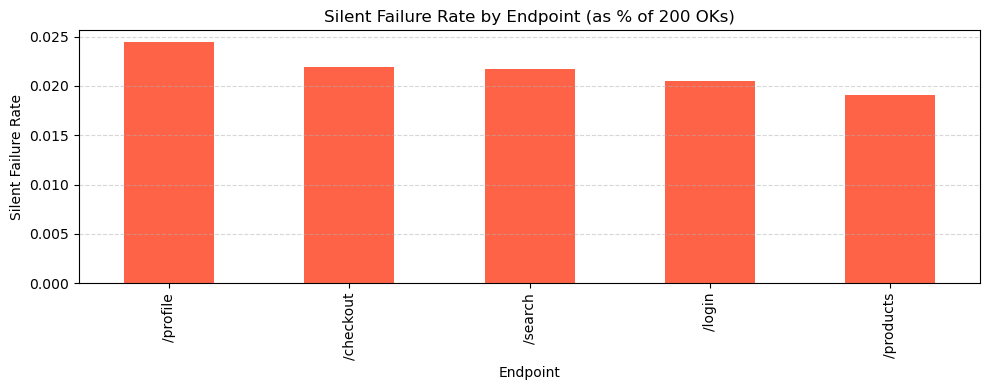

In [51]:
# Total 200 OK requests per endpoint
total_200 = df[df['status_code'] == 200].groupby('endpoint').size()

# Silent failures (200 + payload_valid = False)
silent_failures = df[(df['status_code'] == 200) & (df['payload_valid'] == False)].groupby('endpoint').size()

# Calculate % of silent failures
silent_rate = (silent_failures / total_200).fillna(0).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 4))
silent_rate.plot(kind='bar', color='tomato')
plt.title("Silent Failure Rate by Endpoint (as % of 200 OKs)")
plt.ylabel("Silent Failure Rate")
plt.xlabel("Endpoint")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


<Figure size 1200x500 with 0 Axes>

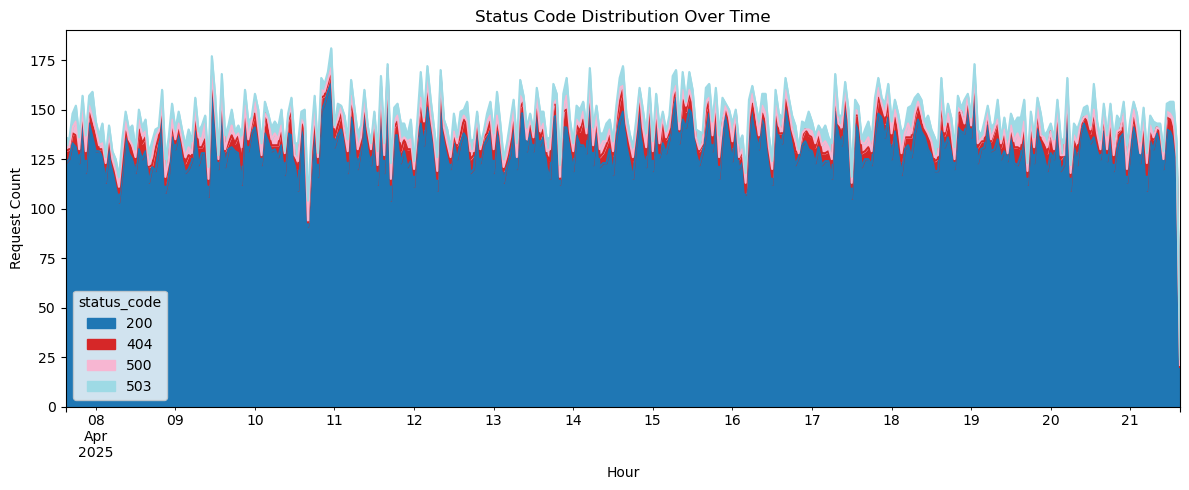

In [52]:
# Round timestamp to hourly
df['hour'] = df['timestamp'].dt.floor('H')

# Group by hour and status code
status_trend = df.groupby(['hour', 'status_code']).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(12, 5))
status_trend.plot.area(stacked=True, colormap='tab20', figsize=(12, 5))
plt.title("Status Code Distribution Over Time")
plt.xlabel("Hour")
plt.ylabel("Request Count")
plt.tight_layout()
plt.show()


# FEATURE ENGINEERING PIELINE

In [53]:
#Create a clean working copy
data = df[[
    'response_time_ms', 'status_code', 'payload_valid',
    'endpoint', 'method', 'env', 'region', 'service_name'
]].copy()

# Handle missing values (if any)
data['payload_valid'] = data['payload_valid'].fillna(False)
data['status_code'] = data['status_code'].fillna(0)

# Define preprocessing pipeline
numeric_features = ['response_time_ms', 'status_code']
categorical_features = ['endpoint', 'method', 'env', 'region', 'service_name']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Transform the data
X_transformed = preprocessor.fit_transform(data)

# Store feature names (optional, useful for debugging)
ohe = preprocessor.named_transformers_['cat']
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_feature_names)

# Convert to DataFrame for exploration
X_df = pd.DataFrame(X_transformed.toarray() if hasattr(X_transformed, "toarray") else X_transformed, columns=feature_names)

# Show shape and preview
print("🔧 Feature matrix shape:", X_df.shape)
X_df.head()

🔧 Feature matrix shape: (49026, 20)


,response_time_ms,status_code,endpoint_/checkout,endpoint_/login,endpoint_/products,endpoint_/profile,endpoint_/search,method_GET,method_POST,method_PUT,env_dev,env_prod,env_staging,region_eu-west,region_us-east,region_us-west,service_name_auth-service,service_name_order-service,service_name_product-service,service_name_user-service
0,0.162884,-0.329444,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-0.409730,-0.329444,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.669033,-0.329444,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.059694,-0.329444,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.619479,-0.329444,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


# ISOLATION FOREST ANOMALY DETECTION

In [54]:
# Step 1: Initialize Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,  # ~5% of the data is assumed to be anomalous
    random_state=42
)

# Step 2: Fit model on feature matrix
iso_forest.fit(X_df)

# Step 3: Predict anomaly (-1 = anomaly, 1 = normal)
df['ml_anomaly_flag'] = iso_forest.predict(X_df)
df['ml_anomaly_score'] = iso_forest.decision_function(X_df)

# Convert -1 to 1 (anomaly), and 1 to 0 (normal)
df['ml_anomaly_flag'] = df['ml_anomaly_flag'].apply(lambda x: 1 if x == -1 else 0)

# Output summary
print("Total anomalies detected by ML model:", df['ml_anomaly_flag'].sum())
df[['timestamp', 'endpoint', 'status_code', 'response_time_ms', 'ml_anomaly_flag', 'ml_anomaly_score']].head()


Total anomalies detected by ML model: 2452


,timestamp,endpoint,status_code,response_time_ms,ml_anomaly_flag,ml_anomaly_score
0,2025-04-16 04:46:13.774056,/checkout,200,290.64,0,0.051034
1,2025-04-21 12:26:13.774056,/profile,200,118.35,0,0.052193
2,2025-04-11 16:26:49.774056,/products,200,40.33,0,0.059792
3,2025-04-18 08:54:49.774056,/login,200,223.67,0,0.052741
4,2025-04-17 01:19:27.774056,/search,200,55.24,0,0.045737


# VISUALIZE ML ANOMALIES OVER TIME

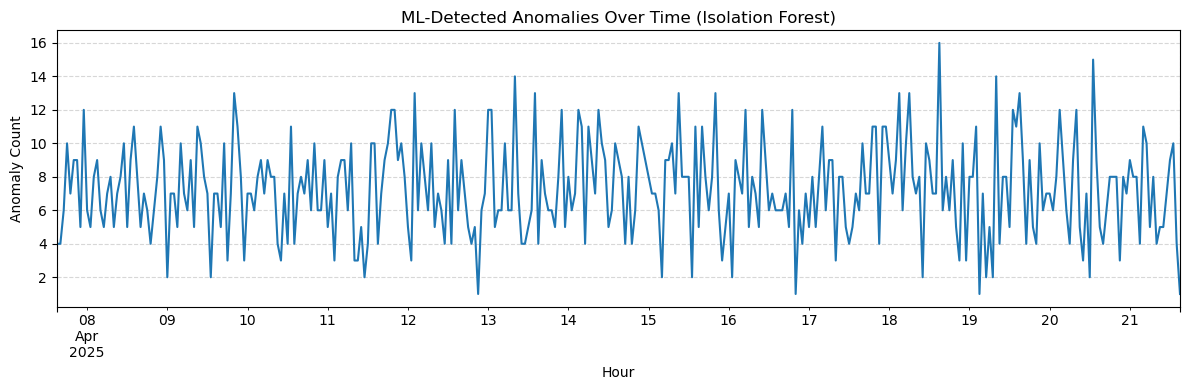

In [55]:
# Round timestamp to hour
df['hour'] = df['timestamp'].dt.floor('H')

# Count of ML anomalies per hour
ml_anomalies_over_time = df[df['ml_anomaly_flag'] == 1].groupby('hour').size()

# Plot
plt.figure(figsize=(12, 4))
ml_anomalies_over_time.plot()
plt.title("ML-Detected Anomalies Over Time (Isolation Forest)")
plt.xlabel("Hour")
plt.ylabel("Anomaly Count")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [56]:
# Create a combined flag for rule-based
rule_cols = ['latency_spike', 'silent_failure', 'volume_drop', 'status_503_spike']
df['rule_based_anomaly'] = df[rule_cols].any(axis=1).astype(int)

# Confusion matrix summary
comparison = pd.crosstab(df['rule_based_anomaly'], df['ml_anomaly_flag'],
                         rownames=['Rule-Based'], colnames=['ML-Based'])

print("ML vs Rule-Based Anomaly Overlap:")
print(comparison)


ML vs Rule-Based Anomaly Overlap:
ML-Based        0     1
Rule-Based             
0           43891   551
1            2683  1901


In [57]:
# Sort by most anomalous
top_ml_anomalies = df[df['ml_anomaly_flag'] == 1].sort_values(by='ml_anomaly_score')
top_ml_anomalies[['timestamp', 'endpoint', 'service_name', 'response_time_ms', 'status_code', 'ml_anomaly_score']].head(10)


,timestamp,endpoint,service_name,response_time_ms,status_code,ml_anomaly_score
35742,2025-04-18 19:00:16.774056,/checkout,auth-service,1867.85,500,-0.056321
34123,2025-04-20 13:58:33.774056,/checkout,product-service,2417.89,503,-0.051139
4733,2025-04-07 18:55:45.774056,/checkout,product-service,2313.90,500,-0.051073
15945,2025-04-21 11:53:25.774056,/login,order-service,3364.93,500,-0.050942
48111,2025-04-11 23:54:50.774056,/profile,order-service,2596.60,503,-0.050942
38409,2025-04-12 08:34:34.774056,/products,order-service,2849.07,500,-0.050385
31081,2025-04-09 14:48:42.774056,/checkout,auth-service,1808.58,500,-0.050050
4412,2025-04-17 05:45:13.774056,/login,product-service,2983.22,503,-0.049869
1734,2025-04-20 19:09:40.774056,/search,user-service,4543.29,500,-0.049575
11082,2025-04-07 20:58:02.774056,/search,user-service,2887.69,503,-0.049277


# Add Rolling Stats to DataFrame

In [58]:
# Sort by timestamp and set time index
df = df.sort_values(by='timestamp').reset_index(drop=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Add rolling features (grouped per endpoint or service)
# You can adjust window='1H' or periods=6 depending on your dataset size

df['rolling_latency_ep'] = (
    df.groupby('endpoint')['response_time_ms']
    .transform(lambda x: x.rolling(window=10, min_periods=1).mean())
)

df['rolling_error_rate_region'] = (
    df.assign(is_error=df['status_code'] >= 400)
      .groupby('region')['is_error']
      .transform(lambda x: x.rolling(window=10, min_periods=1).mean())
)

df['rolling_req_count_service'] = (
    df.groupby('service_name')['service_name']
    .transform(lambda x: x.rolling(window=10, min_periods=1).count())
)

# Fill NA values 
df[['rolling_latency_ep', 'rolling_error_rate_region', 'rolling_req_count_service']] = df[
    ['rolling_latency_ep', 'rolling_error_rate_region', 'rolling_req_count_service']
].fillna(method='bfill')
df.head()

,timestamp,endpoint,method,status_code,response_time_ms,response_size,user_id,service_name,env,region,...,latency_spike,silent_failure,volume_drop,status_503_spike,ml_anomaly_flag,ml_anomaly_score,rule_based_anomaly,rolling_latency_ep,rolling_error_rate_region,rolling_req_count_service
0,2025-04-07 15:09:41.774056,/profile,GET,200,160.41,1238,U88720,product-service,staging,eu-west,...,False,False,False,False,0,0.058038,0,160.41,0.000000,1.0
1,2025-04-07 15:10:09.774056,/search,POST,404,746.74,0,U95246,order-service,prod,eu-west,...,False,False,False,False,0,0.010715,0,746.74,0.500000,1.0
2,2025-04-07 15:10:19.774056,/login,PUT,200,252.48,1532,U85196,product-service,dev,eu-west,...,False,False,False,False,0,0.043114,0,252.48,0.333333,2.0
3,2025-04-07 15:10:24.774056,/checkout,PUT,200,172.77,978,U56458,auth-service,dev,us-west,...,False,False,False,False,0,0.059521,0,172.77,0.000000,1.0
4,2025-04-07 15:10:54.774056,/search,PUT,200,13.02,906,U94204,user-service,dev,eu-west,...,False,False,False,False,0,0.041612,0,379.88,0.250000,1.0


# Adding some more complex rolling features 

In [59]:
# Pre-create error categories
df['is_4xx'] = df['status_code'].between(400, 499)
df['is_5xx'] = df['status_code'] >= 500
df['is_error'] = df['status_code'] >= 400

# 1. Rolling std dev of latency per endpoint
df['rolling_latency_std_ep'] = (
    df.groupby('endpoint')['response_time_ms']
    .transform(lambda x: x.rolling(window=10, min_periods=1).std())
)

# 2. Rolling error rate by env + endpoint
df['env_endpoint'] = df['env'] + '_' + df['endpoint']
df['rolling_error_rate_env_endpoint'] = (
    df.groupby('env_endpoint')['is_error']
    .transform(lambda x: x.rolling(window=10, min_periods=1).mean())
)

# 3. Rolling 4xx error ratio by region
df['rolling_4xx_ratio_region'] = (
    df.groupby('region')['is_4xx']
    .transform(lambda x: x.rolling(window=10, min_periods=1).mean())
)

# 4. Rolling 5xx error ratio by service
df['rolling_5xx_ratio_service'] = (
    df.groupby('service_name')['is_5xx']
    .transform(lambda x: x.rolling(window=10, min_periods=1).mean())
)

# Optional: Fill initial NAs
df.fillna(method='bfill', inplace=True)
df.head()

,timestamp,endpoint,method,status_code,response_time_ms,response_size,user_id,service_name,env,region,...,rule_based_anomaly,rolling_latency_ep,rolling_error_rate_region,rolling_req_count_service,is_4xx,rolling_latency_std_ep,env_endpoint,rolling_error_rate_env_endpoint,rolling_4xx_ratio_region,rolling_5xx_ratio_service
0,2025-04-07 15:09:41.774056,/profile,GET,200,160.41,1238,U88720,product-service,staging,eu-west,...,0,160.41,0.000000,1.0,False,518.818387,staging_/profile,0.0,0.000000,0.0
1,2025-04-07 15:10:09.774056,/search,POST,404,746.74,0,U95246,order-service,prod,eu-west,...,0,746.74,0.500000,1.0,True,518.818387,prod_/search,1.0,0.500000,0.0
2,2025-04-07 15:10:19.774056,/login,PUT,200,252.48,1532,U85196,product-service,dev,eu-west,...,0,252.48,0.333333,2.0,False,518.818387,dev_/login,0.0,0.333333,0.0
3,2025-04-07 15:10:24.774056,/checkout,PUT,200,172.77,978,U56458,auth-service,dev,us-west,...,0,172.77,0.000000,1.0,False,518.818387,dev_/checkout,0.0,0.000000,0.0
4,2025-04-07 15:10:54.774056,/search,PUT,200,13.02,906,U94204,user-service,dev,eu-west,...,0,379.88,0.250000,1.0,False,518.818387,dev_/search,0.0,0.250000,0.0


# Tuning isolation contamination model

In [60]:
# Re-run model with tuned contamination 
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,  
    random_state=42
)

iso_forest.fit(X_df)
df['ml_anomaly_flag'] = (iso_forest.predict(X_df) == -1).astype(int)
df['ml_anomaly_score'] = iso_forest.decision_function(X_df)

# Show summary
anomaly_count = df['ml_anomaly_flag'].sum()
print(f"ML anomalies detected: {anomaly_count} out of {len(df)}")

# Show top anomalous rows 
if anomaly_count > 0:
    display(df[df['ml_anomaly_flag'] == 1].sort_values(by='ml_anomaly_score').head())
else:
    print("No anomalies detected. Try increasing contamination or adjusting features.")


ML anomalies detected: 2452 out of 49026


,timestamp,endpoint,method,status_code,response_time_ms,response_size,user_id,service_name,env,region,...,rule_based_anomaly,rolling_latency_ep,rolling_error_rate_region,rolling_req_count_service,is_4xx,rolling_latency_std_ep,env_endpoint,rolling_error_rate_env_endpoint,rolling_4xx_ratio_region,rolling_5xx_ratio_service
35742,2025-04-17 20:08:46.774056,/products,POST,200,75.54,1455,U16994,auth-service,prod,eu-west,...,0,109.781,0.1,10.0,False,98.322120,prod_/products,0.1,0.0,0.1
34123,2025-04-17 09:01:18.774056,/checkout,PUT,200,983.54,1130,U57256,order-service,prod,eu-west,...,1,373.589,0.1,10.0,False,393.639864,prod_/checkout,0.1,0.1,0.1
4733,2025-04-09 00:45:19.774056,/search,PUT,200,85.84,2464,U27289,product-service,prod,eu-west,...,0,214.771,0.1,10.0,False,132.350314,prod_/search,0.0,0.1,0.1
15945,2025-04-12 05:28:44.774056,/login,POST,200,220.76,1393,U11076,product-service,prod,us-west,...,0,308.084,0.0,10.0,False,476.064318,prod_/login,0.1,0.0,0.0
48111,2025-04-21 08:46:36.774056,/search,GET,200,203.18,1274,U27394,user-service,staging,eu-west,...,0,176.071,0.0,10.0,False,119.055447,staging_/search,0.0,0.0,0.0


# PROPHET MODEL TO FORECAST ANOMALIES OR DETECT ANOMAILES

09:17:06 - cmdstanpy - INFO - Chain [1] start processing
09:17:06 - cmdstanpy - INFO - Chain [1] done processing


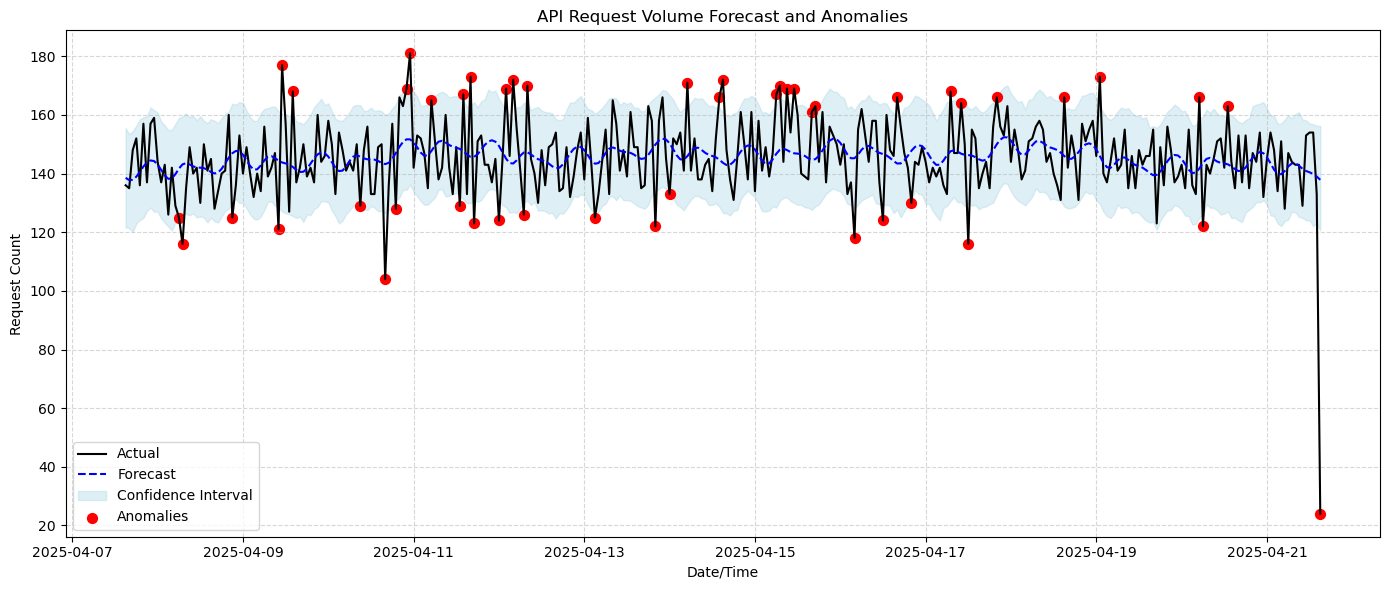

Detected anomalies:


,ds,y,yhat,yhat_lower,yhat_upper,anomaly
15,2025-04-08 06:00:00,125,141.706050,125.422344,158.983706,-1
16,2025-04-08 07:00:00,116,143.134085,126.587507,159.486341,-1
30,2025-04-08 21:00:00,125,146.935244,130.190031,163.832424,-1
43,2025-04-09 10:00:00,121,144.395968,128.331796,161.279931,-1
44,2025-04-09 11:00:00,177,143.783812,127.067852,160.374895,1
47,2025-04-09 14:00:00,168,142.273110,125.535366,160.955445,1
66,2025-04-10 09:00:00,129,145.798703,129.244174,163.270198,-1
73,2025-04-10 16:00:00,104,143.231706,126.463816,159.987649,-1
76,2025-04-10 19:00:00,128,147.033482,130.706558,163.566146,-1
79,2025-04-10 22:00:00,169,151.681903,134.439141,167.991870,1


In [61]:
# Prepare Data
df['hour'] = df['timestamp'].dt.floor('H')
api_volume = df.groupby('hour').size().reset_index(name='y')
api_volume.rename(columns={'hour': 'ds'}, inplace=True)

# Train Prophet Model
m = Prophet()
m.fit(api_volume)

# Predict Future
future = m.make_future_dataframe(periods=24, freq='H')  # Predict 24 hours ahead
forecast = m.predict(future)

# Merge Forecast with Actual
merged = pd.merge(api_volume, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

# Detect Anomalies
merged['anomaly'] = 0
merged.loc[merged['y'] < merged['yhat_lower'], 'anomaly'] = -1  # Unexpected drop
merged.loc[merged['y'] > merged['yhat_upper'], 'anomaly'] = 1   # Unexpected surge

# Plot with Anomalies Highlighted
plt.figure(figsize=(14, 6))
plt.plot(merged['ds'], merged['y'], label='Actual', color='black')
plt.plot(merged['ds'], merged['yhat'], label='Forecast', color='blue', linestyle='--')
plt.fill_between(merged['ds'], merged['yhat_lower'], merged['yhat_upper'], color='lightblue', alpha=0.4, label='Confidence Interval')

# Highlight anomalies
anomalies = merged[merged['anomaly'] != 0]
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Anomalies', s=50)

plt.title('API Request Volume Forecast and Anomalies')
plt.xlabel('Date/Time')
plt.ylabel('Request Count')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Display Anomalies 
print("Detected anomalies:")
display(merged[merged['anomaly'] != 0])


# AUTO CATEGORIZING THE ANOMALIES

In [62]:
# Create a new 'anomaly_category' column
def categorize_anomaly(row):
    if row['anomaly'] == -1:
        return 'Critical Traffic Drop'
    elif row['anomaly'] == 1:
        return 'Unexpected Traffic Surge'
    else:
        return 'Normal'

merged['anomaly_category'] = merged.apply(categorize_anomaly, axis=1)

# Display
print("Auto-Categorized Anomalies:")
display(merged[merged['anomaly_category'] != 'Normal'][['ds', 'y', 'yhat', 'anomaly_category']])


Auto-Categorized Anomalies:


,ds,y,yhat,anomaly_category
15,2025-04-08 06:00:00,125,141.706050,Critical Traffic Drop
16,2025-04-08 07:00:00,116,143.134085,Critical Traffic Drop
30,2025-04-08 21:00:00,125,146.935244,Critical Traffic Drop
43,2025-04-09 10:00:00,121,144.395968,Critical Traffic Drop
44,2025-04-09 11:00:00,177,143.783812,Unexpected Traffic Surge
47,2025-04-09 14:00:00,168,142.273110,Unexpected Traffic Surge
66,2025-04-10 09:00:00,129,145.798703,Critical Traffic Drop
73,2025-04-10 16:00:00,104,143.231706,Critical Traffic Drop
76,2025-04-10 19:00:00,128,147.033482,Critical Traffic Drop
79,2025-04-10 22:00:00,169,151.681903,Unexpected Traffic Surge


# MASTER ANOMALY TABLE

In [63]:
# Define advanced rolling features
ml_features = [
    'response_time_ms', 'status_code',
    'rolling_latency_ep', 'rolling_latency_std_ep',
    'rolling_error_rate_region', 'rolling_req_count_service',
    'rolling_error_rate_env_endpoint'
]

# Fill missing values
X_advanced = df[ml_features].fillna(method='bfill').fillna(method='ffill')

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_advanced)

# Train Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.03, random_state=42)
iso_forest.fit(X_scaled)

# Predict
df['ml_anomaly_flag_v2'] = (iso_forest.predict(X_scaled) == -1).astype(int)
df['ml_anomaly_score_v2'] = iso_forest.decision_function(X_scaled)

print("Isolation Forest retrained and ML anomalies added!")

# Step 2: Merge Prophet + ML into Master Table

# Prepare Prophet anomalies (merged already exists from previous Prophet modeling)
prophet_anomalies = merged[['ds', 'y', 'yhat', 'anomaly_category']].copy()
prophet_anomalies.rename(columns={
    'ds': 'timestamp',
    'y': 'actual_request_count',
    'yhat': 'predicted_request_count',
    'anomaly_category': 'prophet_anomaly_category'
}, inplace=True)

# Prepare ML anomalies
ml_anomalies = df[['timestamp', 'ml_anomaly_flag_v2', 'ml_anomaly_score_v2']]

# Merge Prophet + ML anomalies
master_anomalies = pd.merge(prophet_anomalies, ml_anomalies, on='timestamp', how='left')

# Fill missing ML anomaly flags if any
master_anomalies['ml_anomaly_flag_v2'] = master_anomalies['ml_anomaly_flag_v2'].fillna(0).astype(int)
master_anomalies['ml_anomaly_score_v2'] = master_anomalies['ml_anomaly_score_v2'].fillna(0)

# Create final combined anomaly flag
master_anomalies['final_combined_anomaly_flag'] = 0
master_anomalies.loc[
    (master_anomalies['prophet_anomaly_category'] != 'Normal') | 
    (master_anomalies['ml_anomaly_flag_v2'] == 1), 
    'final_combined_anomaly_flag'
] = 1

print("Master Anomaly Table created successfully!")

# Step 3: Display
display(master_anomalies.head(10))


Isolation Forest retrained and ML anomalies added!
Master Anomaly Table created successfully!


,timestamp,actual_request_count,predicted_request_count,prophet_anomaly_category,ml_anomaly_flag_v2,ml_anomaly_score_v2,final_combined_anomaly_flag
0,2025-04-07 15:00:00,136,138.541411,Normal,0,0.0,0
1,2025-04-07 16:00:00,135,137.794438,Normal,0,0.0,0
2,2025-04-07 17:00:00,148,137.876641,Normal,0,0.0,0
3,2025-04-07 18:00:00,152,138.922945,Normal,0,0.0,0
4,2025-04-07 19:00:00,136,140.612158,Normal,0,0.0,0
5,2025-04-07 20:00:00,157,142.400431,Normal,0,0.0,0
6,2025-04-07 21:00:00,137,143.798255,Normal,0,0.0,0
7,2025-04-07 22:00:00,157,144.480619,Normal,0,0.0,0
8,2025-04-07 23:00:00,159,144.260455,Normal,0,0.0,0
9,2025-04-08 00:00:00,144,143.104089,Normal,0,0.0,0


# SUMMARY STATS

In [65]:
# Prophet-Based Anomaly Counts
prophet_summary = master_anomalies['prophet_anomaly_category'].value_counts()

# ML-Based Isolation Forest Anomaly Counts
ml_summary = master_anomalies['ml_anomaly_flag_v2'].value_counts()

# Combined Final Anomalies
final_summary = master_anomalies['final_combined_anomaly_flag'].value_counts()

# Display Neatly
print("\nProphet-Based Anomaly Summary:")
print(prophet_summary)

print("\nIsolation Forest (ML-Based) Anomaly Summary:")
print(f"Normal: {ml_summary.get(0, 0)}\nML-Detected Anomalies: {ml_summary.get(1, 0)}")

print("\nFinal Combined Anomalies Summary:")
print(f"Normal: {final_summary.get(0, 0)}\nDetected Anomalies (Prophet or ML): {final_summary.get(1, 0)}")


Prophet-Based Anomaly Summary:
Normal                      290
Unexpected Traffic Surge     27
Critical Traffic Drop        20
Name: prophet_anomaly_category, dtype: int64

Isolation Forest (ML-Based) Anomaly Summary:
Normal: 337
ML-Detected Anomalies: 0

Final Combined Anomalies Summary:
Normal: 290
Detected Anomalies (Prophet or ML): 47
